In [ ]:
! pip install numpyro corner healpy einops reproject

In [ ]:
#! pip install --upgrade  "jax[cuda]"==0.4.1 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html numpyro==0.10.1 corner healpy tensorflow-probability arviz einops reproject

In [ ]:
# run only if LaTeX is needed
! sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r'/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/')
%cd /content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks

Mounted at /content/drive
/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks


In [ ]:
import sys
import pickle
sys.path.append("../")

from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import corner
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans"
})

from models.nptf import NPModel

%reload_ext autoreload
%autoreload 2

In [ ]:
npmodel = NPModel(
    # Which diffuse models to use
    dif_names=["ModelO", "ModelA", "ModelF"],  
    # Which combination of bulge templates to use; see BulgeTemplates in `templates/rigid_templates.py`
    bulge_template_names=["mcdermott2022", "mcdermott2022_bbp", "mcdermott2022_x", "macias2019", "coleman2019"],  
    ps_cat="3fgl",  # PS catalog; only 3fgl for now
    r_outer=25,  # Outer radius mask
    band_mask_range=2.0,  # Latitude band maek
    nside=128,  # Healpix nside
    n_exp=1,  # Number of exposure regions
)

Loading the psf correction from: ../data/psf_dir/Fermi_PSF_2GeV2_nside128.npy
Max photon count is 103


In [ ]:
# Run SVI (~30min on T4, ~10min on V100, ~4min on A100, minus compile time)
svi_results = npmodel.fit_svi(rng_key=jax.random.PRNGKey(42), n_steps=5000)

In [ ]:
# Get samples from posterior
arviz_post = npmodel.get_posterior_samples(rng_key=jax.random.PRNGKey(42), num_samples=50_000)

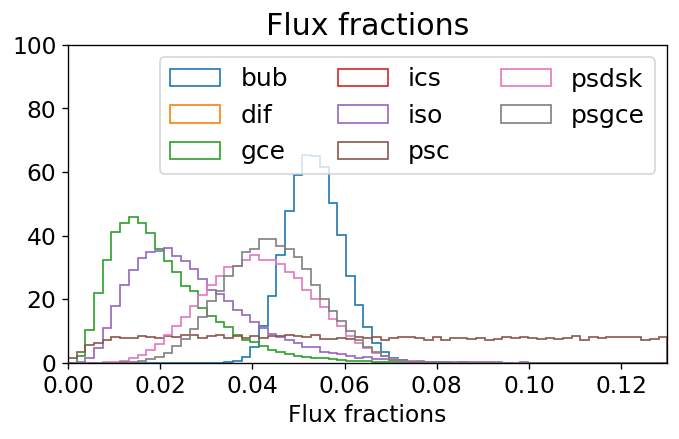

In [ ]:
S_post = np.array([v for k,v in arviz_post.items() if k.startswith('S')])
S_labels = np.array([k for k,v in arviz_post.items() if k.startswith('S')])

flux_fraction_post = S_post / np.sum(S_post, axis=0)[None, :]

ff_max = 0.13
ff_bins = 70

bins = np.linspace(0, ff_max, ff_bins)
for i in range(len(flux_fraction_post)):
    plt.hist(flux_fraction_post[i], bins=bins, label=S_labels[i].replace("_", "")[1:], histtype='step', density=True)
    
plt.xlim(0, ff_max)
plt.ylim(0, 100)
plt.legend(ncol=3, fontsize=15)

plt.xlabel("Flux fractions")
plt.title("Flux fractions")

plt.tight_layout()